In [1]:
import numpy as np
import xarray as xr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import areamean_dhq as areamean
import copy
import dyl_function_slope as dyl
import cmaps
sequence_font={
    'style': "Helvetica",
    'weight': "bold",
    'fontsize':7
}
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['figure.figsize'] = (6, 6)
ccmap = cmaps.cmp_b2r

# 定义函数

In [2]:
def plot_trend_and_significance_ssp(axes, data, trend, p_values, title, sequence, exp, levels, levels2,
                                    ccmap, climatology=None):
    ax = fig.add_axes(axes, projection=ccrs.Robinson())
    ax.set_global()
    ax.set_aspect(1.25)
    # 为数据添加周期性点
    trend_cyclic, lon_cyclic = add_cyclic_point(trend, coord=data['lon'])
    # 确保一致性掩码也添加周期性点
    consistency_mask_cyclic, _ = add_cyclic_point(p_values, coord=data['lon'])
    # Plot the trend
    cf = ax.contourf(lon_cyclic, data['lat'], trend_cyclic, levels=levels, cmap=ccmap, extend='both',
                     transform=ccrs.PlateCarree())
    ax.coastlines(lw=0.5)
    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}
    # Plot the significance
    significance = np.ma.masked_where(p_values >= 0.05, p_values)
    cc = ax.contourf(data['lon'], data['lat'], significance, hatches=['...'], colors='none',
                     transform=ccrs.PlateCarree())
    for j, collection in enumerate(cc.collections):  ############更改打点的颜色
        collection.set_edgecolor('grey')
    for collection in cc.collections:
        collection.set_linewidth(0)

    if climatology:
        clim_cyclic, _ = add_cyclic_point(climatology, coord=data['lon'])
        c2 = ax.contour(lon_cyclic, data['lat'], clim_cyclic, levels=levels2, colors='m', alpha=1, linewidths=.5,
                        transform=ccrs.PlateCarree())
        ax.clabel(c2, colors='k', inline=True, fontsize=6)
    # Set the title
    #ax.set_title(title, fontsize=7)
    ax.text(-0.1, 1.1, sequence, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    ax.text(.7, 1.1, exp, transform=ax.transAxes, fontsize=7, va='top', ha='left')
    return cf


def plot_zonmean_diff(ax, trend_zonmean, linesty, lat, title, sequence, xlim,std_diff=None,linecolor=None):
    # 计算100hPa和200hPa的纬向风差值
    latitudes = lat.values
    if linecolor:
        linec = linecolor
    else:
        linec = 'k'
    # 绘制集合平均
    trend_zonmean_line = ax.plot(trend_zonmean, latitudes, linec,linestyle=linesty, linewidth=1)
    if std_diff is not None:
    # 填充模型间一倍标准差
        ax.fill_betweenx(latitudes, trend_zonmean - std_diff, trend_zonmean + std_diff, color=linec, alpha=0.2)
    ax.fill_between(xlim, -20, -40, color='dodgerblue', alpha=0.02)
    ax.fill_between(xlim, 20, 40, color='dodgerblue', alpha=0.02)
    # 绘制竖直0刻度线
    ax.axvline(0, color='grey', linewidth=.5)
    # 设置横纵坐标范围
    ax.set_xlim(xlim)
    ax.set_ylim([-90, 90])
    #ax.xaxis.set_major_locator(MultipleLocator(2))
    #ax.yaxis.set_major_locator(MultipleLocator(0.4))
    # 设置纬度标签
    ax.set_yticks(np.arange(-90, 91, 30))
    ax.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
    ax.tick_params(axis='both', which='major', direction='in',labelsize=7)
    # 设置标题
    #ax.set_title(title, fontsize=7)
    # 设置坐标轴标签
    ax.text(-.28, 1.1, sequence, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    return trend_zonmean_line


# 读取数据

In [3]:
##读取ghg aer o3数据

hist_GHG = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-GHG/ua_hist-GHG_all_models_1958-2019_288x145_zonmean.nc').ua[:,12:,:,:,0]
#hist_GHG2 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-GHG/ua_hist-GHG_all_models_197901-202012_zonmean_historical_288x145.nc').ua
hist_aer = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-aer/ua_hist-aer_all_models_1958-2019_288x145_zonmean.nc').ua[:,12:,:,:,0]
#hist_aer2 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-aer/ua_hist-aer_all_models_197901-202012_zonmean_historical_288x145.nc').ua
hist_GHG_trend_zonmean_all_models, _ = dyl.calculate_trend_3D_zonmean(hist_GHG[:, :, 11] - hist_GHG[:, :, 9])
hist_aer_trend_zonmean_all_models, _ = dyl.calculate_trend_3D_zonmean(hist_aer[:, :, 11] - hist_aer[:, :, 9])
hist_GHG_trend_zonmean, hist_GHG_p_values_zonmean = dyl.calculate_trend_2D(
    hist_GHG[:, :, 11].mean(dim=hist_GHG.dims[0], skipna=True) - hist_GHG[:, :, 9].mean(
        dim=hist_GHG.dims[0], skipna=True))
hist_aer_trend_zonmean, hist_aer_p_values_zonmean = dyl.calculate_trend_2D(
    hist_aer[:, :, 11].mean(dim=hist_aer.dims[0], skipna=True) - hist_aer[:, :, 9].mean(
        dim=hist_aer.dims[0], skipna=True))
hist_GHG_trend_zonmean_std = np.nanstd(hist_GHG_trend_zonmean_all_models * 10, 0)
hist_aer_trend_zonmean_std = np.nanstd(hist_aer_trend_zonmean_all_models * 10, 0)

hist_GHG_climatology = np.nanmean(np.nanmean(hist_GHG, axis=0), axis=0)
hist_GHG_climatology_zonmean_allmodels = np.nanmean(hist_GHG, axis=1)
hist_aer_climatology = np.nanmean(np.nanmean(hist_aer, axis=0), axis=0)
hist_aer_climatology_zonmean_allmodels = np.nanmean(hist_aer, axis=1)

/tmp/ipykernel_232455/4047525179.py:19: RuntimeWarning: Mean of empty slice
  hist_GHG_climatology_zonmean_allmodels = np.nanmean(hist_GHG, axis=1)
/tmp/ipykernel_232455/4047525179.py:21: RuntimeWarning: Mean of empty slice
  hist_aer_climatology_zonmean_allmodels = np.nanmean(hist_aer, axis=1)


# 绘图

/tmp/ipykernel_232455/2979246988.py:38: RuntimeWarning: Mean of empty slice
  hist_o3_climatology_zonmean = np.nanmean(np.nanmean(hist_o3,axis=3),axis=0)
/tmp/ipykernel_232455/2979246988.py:38: RuntimeWarning: Mean of empty slice
  hist_o3_climatology_zonmean = np.nanmean(np.nanmean(hist_o3,axis=3),axis=0)
/tmp/ipykernel_232455/2979246988.py:38: RuntimeWarning: Mean of empty slice
  hist_o3_climatology_zonmean = np.nanmean(np.nanmean(hist_o3,axis=3),axis=0)
/tmp/ipykernel_232455/2979246988.py:38: RuntimeWarning: Mean of empty slice
  hist_o3_climatology_zonmean = np.nanmean(np.nanmean(hist_o3,axis=3),axis=0)
/tmp/ipykernel_232455/2979246988.py:38: RuntimeWarning: Mean of empty slice
  hist_o3_climatology_zonmean = np.nanmean(np.nanmean(hist_o3,axis=3),axis=0)
/tmp/ipykernel_232455/2979246988.py:38: RuntimeWarning: Mean of empty slice
  hist_o3_climatology_zonmean = np.nanmean(np.nanmean(hist_o3,axis=3),axis=0)
/tmp/ipykernel_232455/2979246988.py:38: RuntimeWarning: Mean of empty slice


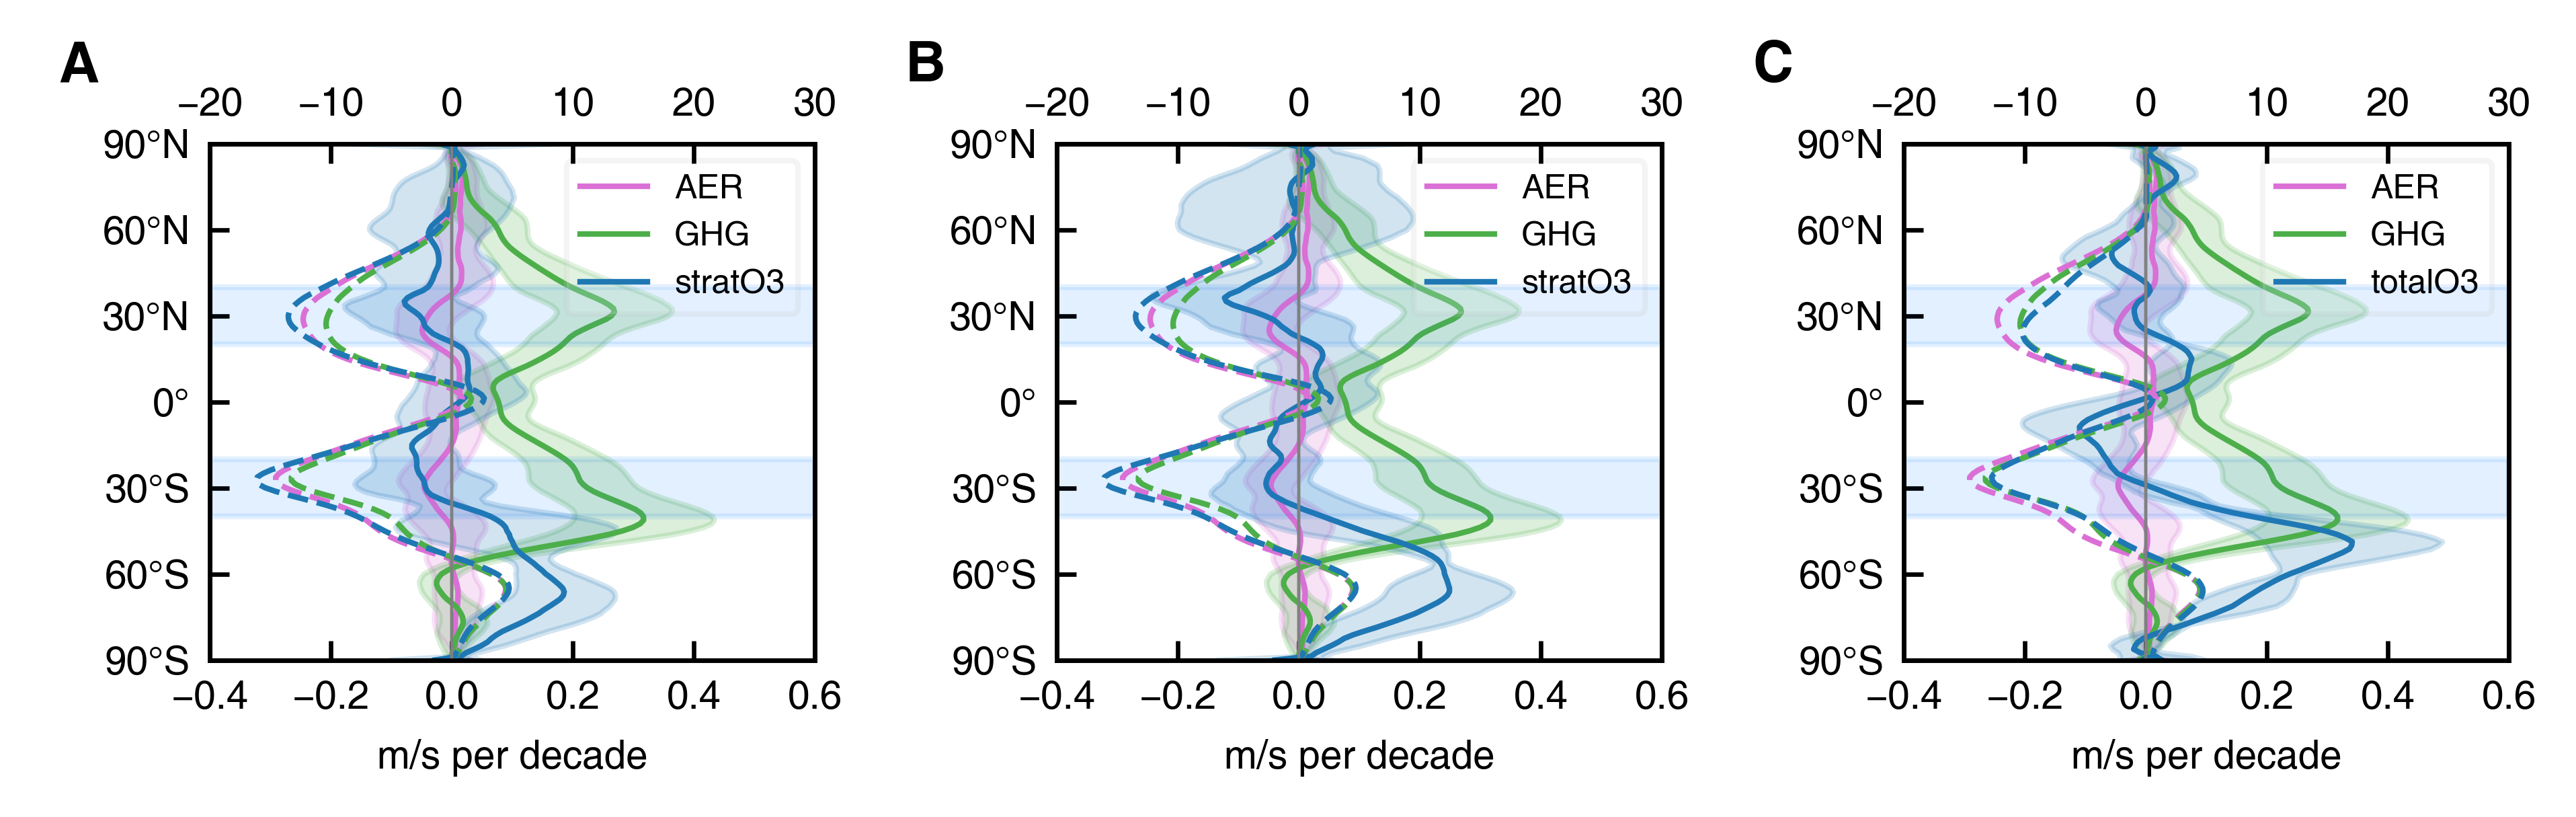

In [5]:
# 原始 figure 和子图定义
#fig = plt.figure(figsize=(7.5,4),dpi=600)
#ax6 = fig.add_axes([0.1, 0.14, 0.2, 0.32])
# 计算 ax6 的绝对尺寸（英寸）
ax6_abs_width = 7.5 * 0.2  # 1.5 英寸
ax6_abs_height = 4 * 0.32   # 1.28 英寸
# 新 figure 的尺寸（假设我们想要宽度=6英寸，高度按比例调整）
new_fig_width = 7  # 可调整
new_fig_height = 2  # 必须保持不变，否则 ax6 的绝对高度会变
# 计算新的归一化 width 和 height
new_ax_width = ax6_abs_width / new_fig_width  # 1.5 / 6 = 0.25
new_ax_height = ax6_abs_height / new_fig_height  # 1.28 / 4 = 0.32
# 创建新 figure
new_fig = plt.figure(figsize=(new_fig_width, new_fig_height), dpi=600)
# 在新 figure 中添加子图（调整 width 和 height 以保持绝对尺寸不变）
sub_axes = [[0.1, 0.16, new_ax_width, new_ax_height],
            [0.4, 0.16, new_ax_width, new_ax_height],
            [0.7, 0.16, new_ax_width, new_ax_height]]

hist_strato3_models = ["CanESM5", "IPSL-CM6A-LR", "MIROC6", "MRI-ESM2-0"]
hist_totalo3_models = ["CanESM5", "GISS-E2-1-G", "MPI-ESM1-2-LR"]
model_list = [hist_strato3_models,hist_strato3_models,hist_totalo3_models]
year_list = ['2020-12-31','2014-12-31','2014-12-31']
sequence = ['A','B','C']
for i in range(3):
    hist_o3_trend_zonmean_all_models = []
    hist_o3_climatology_zonmean_all_models = []
    for m, model in enumerate(model_list[i]):
        if i==2:
            file_path = f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-totalO3/ua_hist-totalO3_{model}_1957-2014_289x145.nc'
        else:
            file_path = f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-stratO3/ua_hist-stratO3_{model}_1957-2020_289x145.nc'
        ds=xr.open_dataset(file_path).sel(time=slice('1980-01-01', year_list[i]))
        hist_o3 = ds.ua
        hist_o3_trend_zonmean,_ = dyl.calculate_trend_2D(hist_o3[:,11].mean(dim=hist_o3.dims[-1],skipna=True)-
                                                         hist_o3[:,9].mean(dim=hist_o3.dims[-1],skipna=True))
        hist_o3_trend_zonmean_all_models.append(hist_o3_trend_zonmean)
        hist_o3_climatology_zonmean = np.nanmean(np.nanmean(hist_o3,axis=3),axis=0)
        hist_o3_climatology_zonmean_all_models.append(hist_o3_climatology_zonmean)
    hist_o3_trend_zonmean_all_models = np.stack(hist_o3_trend_zonmean_all_models)
    hist_o3_trend_zonmean = np.nanmean(hist_o3_trend_zonmean_all_models,axis=0)
    hist_o3_climatology_zonmean_all_models=np.stack(hist_o3_climatology_zonmean_all_models)
    hist_o3_climatology_zonmean = np.nanmean(hist_o3_climatology_zonmean_all_models,axis=0)
    hist_o3_trend_zonmean_std = np.nanstd(hist_o3_trend_zonmean_all_models * 120, 0)

    leftlon, rightlon, lowerlat, upperlat = (-180, 181, -90, 90)
    levels = np.linspace(-1, 1, 11)
    levels2 = np.linspace(-20, 40, 7)

    # 添加子图并调整大小
    ax_new = new_fig.add_axes(sub_axes[i])
    ax_new_ = ax_new.twiny()

    '''signal_colors = {
        'ALL': '#E31A1C',  # 活力红
        'GHG': '#4DAF4A',   # 浅绿色
        'AER': '#DA70D6',  # 鲜艳紫
        'NAT': '#FF7F00'  # 亮黄色
        'O3':'#1F78B4' #臭氧蓝
    }'''
    trend_zonmean_line_aer, = plot_zonmean_diff(ax_new, hist_aer_trend_zonmean * 10, '-', hist_aer.lat, r'$u_{100}$ - $u_{200}$',
                      '',(-.4, .6),hist_aer_trend_zonmean_std,linecolor='#DA70D6')
    trend_zonmean_line_GHG, = plot_zonmean_diff(ax_new, hist_GHG_trend_zonmean * 10, '-', hist_GHG.lat, r'$u_{100}$ - $u_{200}$',
                      '',(-.4, .6),hist_GHG_trend_zonmean_std,linecolor='#4DAF4A')
    trend_zonmean_line_O3, = plot_zonmean_diff(ax_new, hist_o3_trend_zonmean * 120, '-', hist_GHG.lat, r'$u_{100}$ - $u_{200}$',
                      '',(-.4, .6),hist_o3_trend_zonmean_std,linecolor='#1F78B4')

    ax_new.set_xticks(np.linspace(-.4, .6, 6))
    plot_zonmean_diff(ax_new_, hist_aer_climatology[11]-hist_aer_climatology[9],
                      '--', hist_aer.lat, ' ',' ',(-20,30),
                      linecolor='#DA70D6')
    #np.std(hist_aer_climatology_zonmean_allmodels[:,11]-hist_aer_climatology_zonmean_allmodels[:,9],axis=0),
    plot_zonmean_diff(ax_new_, hist_GHG_climatology[11]-hist_GHG_climatology[9],
                      '--', hist_GHG.lat, ' ',' ',(-20,30),
                      linecolor='#4DAF4A')
    plot_zonmean_diff(ax_new_, hist_o3_climatology_zonmean[11]-hist_o3_climatology_zonmean[9],
                      '--', hist_GHG.lat, ' ',' ',(-20,30),
                      linecolor='#1F78B4')
    #np.std(hist_GHG_climatology_zonmean_allmodels[:,11]-hist_GHG_climatology_zonmean_allmodels[:,9],axis=0),

    ax_new_.set_xticks(np.linspace(-20, 30, 6))
    ax_new.set_xlabel('m/s per decade', fontsize=7)
    ax_new.text(-0.25, 1.2, sequence[i], transform=ax_new.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    if i==2:
        ax_new.legend(handles=[trend_zonmean_line_aer, trend_zonmean_line_GHG, trend_zonmean_line_O3],
                      labels=['AER', 'GHG', 'totalO3'], fontsize=6, framealpha=0.2, loc='upper right')
    else:
        ax_new.legend(handles=[trend_zonmean_line_aer,trend_zonmean_line_GHG,trend_zonmean_line_O3],
                      labels = ['AER','GHG','stratO3'],fontsize=6,framealpha=0.2,loc='upper right')
plt.savefig(
    '/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S3.GHGaerstrat_totalo3_zonal_trend_1980-2020_100minus200.png',format="png",
    dpi=300)
plt.savefig(
    '/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S3.GHGaerstrat_totalo3_zonal_trend_1980-2020_100minus200.svg',format="svg",
    dpi=300)
plt.show()